#   Number MNIST GAN
##  A Handwritten Digit Generation Network

##   Imports
All library imports are carried out here.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Sequential, load_model
from keras.backend import expand_dims

##   Reference Material
Below are links to all reference material utilised when producing this system.

In [2]:
#   https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229

#   https://towardsdatascience.com/alphabet-gan-ai-generates-english-letters-589637068808

#   https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

##	Discriminator Model
Define a discriminator model

In [3]:
#	This function will return a discriminator model with the default input shape of 28x28 pixels and 1 channel
def define_discriminator_model(shape=(28, 28, 1)):
    #	Declare a sequential model to which layers will be added
    model = Sequential()

    #	Add a Conv2D layer using the following parameters
    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     strides=(2, 2),
                     padding='same',
                     input_shape=shape))

    #   Add a Leaky Relative Unit layer
    model.add(LeakyReLU(alpha=0.2))

    #   Add a Dropout layer
    model.add(Dropout(0.4))

    #   Repeat the same layer pattern
    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     strides=(2, 2),
                     padding='same',
                     input_shape=shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    #   Add a Flatten layer to the model to flatten the input
    model.add(Flatten())

    #   Add a Dense (neural network) layer to the model
    model.add(Dense(units=1,
                    activation='sigmoid'))

    #   Define the optimiser to be used with the model
    optimiser = Adam(learning_rate=0.0002,
                     beta_1=0.5)

    #   Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimiser,
                  metrics=['accuracy'])

    #   Return the model
    return model

##	Generator Model
Define a generator model

In [4]:
#   This function will return a generator model for which the latent dimension is 100 by default
def define_generator_model(latent_dimension=100):
    #	Declare a sequential model to which layers will be added
    model = Sequential()

    #   Foundation for 7x7 image
    num_nodes = 128 * 7 * 7

    #   Add a Dense (neural network) layer
    model.add(Dense(units=num_nodes,
                    input_dim=latent_dimension))

    #   Add a Leaky Rectified Linear Unit layer
    model.add(LeakyReLU(alpha=0.2))

    #   Add a reshape layer to shape the data as desired
    model.add(Reshape((7, 7, 128)))

    #   Upsample the generation to 14x14 using a Conv2DTranspose layer
    model.add(Conv2DTranspose(filters=128,
                              kernel_size=(4, 4),
                              strides=(2, 2),
                              padding='same'))

    #   Add a Leaky Rectified Linear Unit layer
    model.add(LeakyReLU(alpha=0.2))

    #   Upsample the generation to 28x28 using a Conv2DTranspose layer
    model.add(Conv2DTranspose(filters=128,
                              kernel_size=(4, 4),
                              strides=(2, 2),
                              padding='same'))

    #   Add a Leaky Rectified Linear Unit layer
    model.add(LeakyReLU(alpha=0.2))

    #	Add a Conv2D layer using the following parameters
    model.add(Conv2D(filters=1,
                     kernel_size=(7, 7),
                     activation='sigmoid',
                     padding='same'))

    return model

##	Generative Adversarial Network Model
Define a GAN model using the discriminator and generator models defined previously

In [5]:
def define_gan_model(generator, discriminator):
    #   Prevent further training for discriminator
    discriminator.trainable = False

    #	Declare a sequential model to which layers will be added
    model = Sequential()

    #   Add the generator as the first layer
    model.add(generator)

    #   Add the discriminator as the second layer
    model.add(discriminator)

    #   Declare the optimiser for the model
    optimiser = Adam(learning_rate=0.0002,
                     beta_1=0.5)

    #   Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimiser)

    return model

##  Loading and preparing MNIST data
Load and prepare data from the MNIST dataset

In [6]:
#   Function will load and prepare samples from the MNIST dataset
def load_real_samples():
    #   Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    #   Add a third dimension (representing channels)
    x_train = expand_dims(x_train, -1)

    #   Convert to float from unsigned int
    x_train = x_train.numpy().astype('float32')

    #   Scale the dataset from 0,255 to 0,1
    x_train = x_train / 255

    return x_train


#   Function will randomly select loaded samples
def select_real_samples(dataset, num_samples):
    #   Select random values
    random_values = np.random.randint(low=0,
                                      high=dataset.shape[0],
                                      size=num_samples)

    #   Get selected data
    random_data = dataset[random_values]

    #   Generate class labels for the data
    labels = np.ones((num_samples, 1))

    return random_data, labels

##  Create fake values
Generate random latent points and produce fake data using the generator model

In [7]:
#   Function will generate points in latent space for use as input with generator
def generate_latent_values(latent_dimension, num_samples):
    #   Generate random values in latent space
    generated_values = np.random.randn(latent_dimension * num_samples)

    #   Reshape into a batch of inputs for use with the generator
    generated_values = generated_values.reshape(num_samples, latent_dimension)

    return generated_values


#   This function will use the generator model to produce fake examples with labels
def generate_fake_samples(generator, latent_dimension, num_samples):
    #   Generate random values to feed into generator
    input = generate_latent_values(latent_dimension, num_samples)

    #   Make predictions
    fake_data = generator.predict(input)

    #   Generate class labels for the data
    labels = np.zeros((num_samples, 1))

    return fake_data, labels

##  Training the GAN
Training both the generator and discriminator

In [8]:
#   Function will summarise the performance of a given model
def summarise_model_performance(epoch, generator, discriminator, dataset, latent_dimension, num_samples=100):
    #   Load real samples
    real_data, real_labels = select_real_samples(dataset, num_samples)

    #   Evaluate the accuracy of the discriminator using real values
    _, real_accuracy = discriminator.evaluate(real_data, real_labels, verbose=0)

    #   Generate fake samples
    fake_data, fake_labels = generate_fake_samples(generator, latent_dimension, num_samples)

    #   Evaluate the accuracy of the discriminator using fake/ generated values
    _, fake_accuracy = discriminator.evaluate(fake_data, fake_labels, verbose=0)

    #   Summarise the performance data
    print('Real accuracy: %.0f%% Fake accuracy: %.0f%%' % (real_accuracy * 100, fake_accuracy * 100))

    #   Save the model
    filename = 'Generator_Model_%d.h5' % (epoch + 1)
    generator.save(filename)


#   This will train both the generator and discriminator models for the GAN
def train_gan_model(generator, discriminator, gan, dataset, latent_dimension, num_epoch=50, num_batch=250):
    #   Calculate the number of batches per epoch
    batch_per_epoch = int(dataset.shape[0] / num_batch)

    #   Calculate the size of half of a batch
    half_batch = int(num_batch / 2)

    #   Iterate for the number of epochs defined
    for i in range(num_epoch):
        #   Iterate for the number of batches
        for j in range(batch_per_epoch):
            #   Get randomly chosen real data from dataset
            real_data, real_labels = select_real_samples(dataset, half_batch)

            #   Generate fake samples
            fake_data, fake_labels = generate_fake_samples(generator, latent_dimension, half_batch)

            #   Combine real and fake samples to form training set
            data, labels = np.vstack((real_data, fake_data)), np.vstack((real_labels, fake_labels))

            #   Train the discriminator using the mixed dataset
            discriminator_loss, _ = discriminator.train_on_batch(data, labels)

            #   Generate values to feed to the generator model
            generator_input_data = generate_latent_values(latent_dimension, num_batch)
            generator_input_labels = np.ones((num_batch, 1))

            #   Train the generator using the random points
            generator_loss = gan.train_on_batch(generator_input_data, generator_input_labels)

            #   Summarise the data from the run
            print('Epoch: %d Batch: %d of %d Discriminator loss: %.3f, Generator loss: %.3f' % (
                i + 1, j + 1, batch_per_epoch, discriminator_loss, generator_loss))

        #   After each batch, summarise and save the model
        summarise_model_performance(i, generator, discriminator, dataset, latent_dimension)

##  Testing the GAN

In [9]:
#   Create a discriminator and generator model
discriminator_model = define_discriminator_model()
generator_model = define_generator_model(100)

#   Combine these to form a GAN
gan_model = define_gan_model(generator_model, discriminator_model)

#   Load real samples from the MNIST dataset
dataset = load_real_samples()

#   Train the GAN
train_gan_model(generator_model, discriminator_model, gan_model, dataset, 100, 25)

#   Generate latent values to allow the GAN to predict and generate using
latent_values = generate_latent_values(100, 25)

#   Generate values
gan_produced_images = gan_model.predict(latent_values)

Epoch: 1 Batch: 1 of 240 Discriminator loss: 0.699, Generator loss: 0.721
Epoch: 1 Batch: 2 of 240 Discriminator loss: 0.687, Generator loss: 0.740
Epoch: 1 Batch: 3 of 240 Discriminator loss: 0.680, Generator loss: 0.769
Epoch: 1 Batch: 4 of 240 Discriminator loss: 0.667, Generator loss: 0.787
Epoch: 1 Batch: 5 of 240 Discriminator loss: 0.660, Generator loss: 0.809
Epoch: 1 Batch: 6 of 240 Discriminator loss: 0.655, Generator loss: 0.835
Epoch: 1 Batch: 7 of 240 Discriminator loss: 0.648, Generator loss: 0.849
Epoch: 1 Batch: 8 of 240 Discriminator loss: 0.637, Generator loss: 0.863
Epoch: 1 Batch: 9 of 240 Discriminator loss: 0.628, Generator loss: 0.864
Epoch: 1 Batch: 10 of 240 Discriminator loss: 0.630, Generator loss: 0.862
Epoch: 1 Batch: 11 of 240 Discriminator loss: 0.634, Generator loss: 0.856
Epoch: 1 Batch: 12 of 240 Discriminator loss: 0.632, Generator loss: 0.832
Epoch: 1 Batch: 13 of 240 Discriminator loss: 0.635, Generator loss: 0.810
Epoch: 1 Batch: 14 of 240 Discrimi

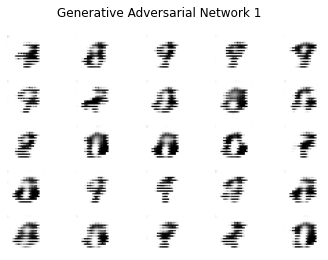

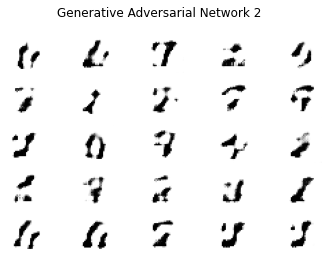

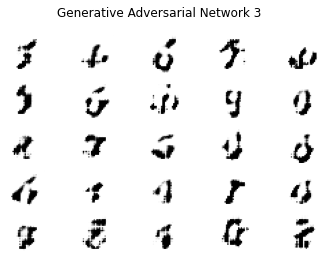

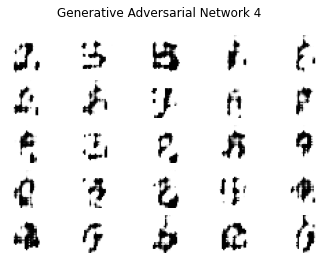

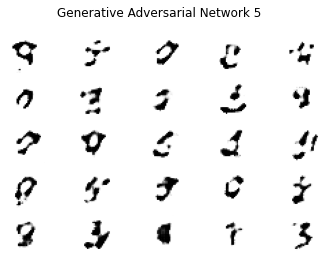

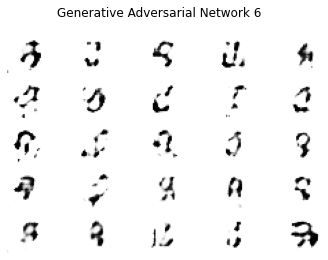

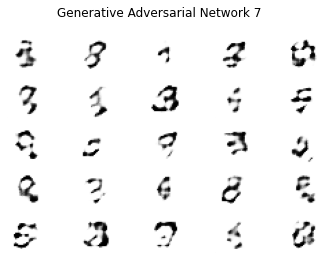

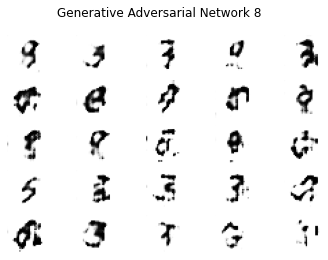

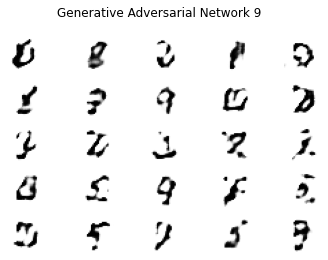

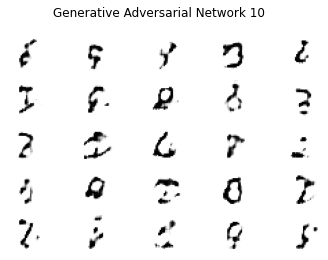

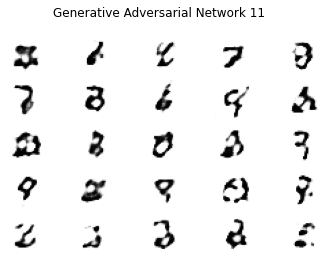

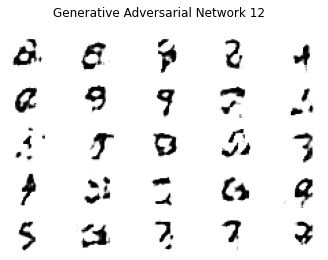

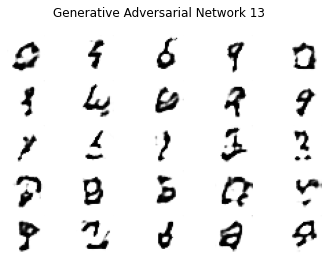

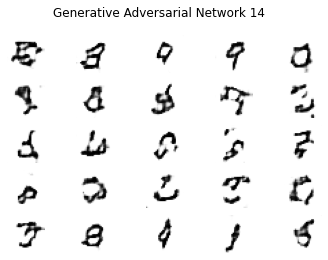

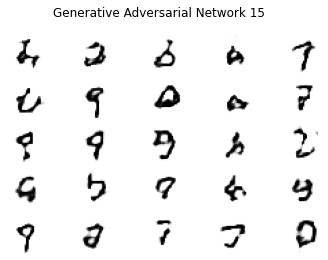

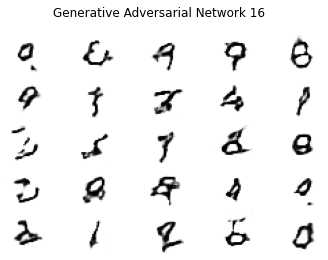

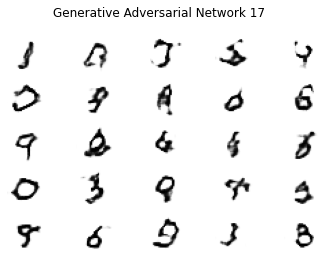

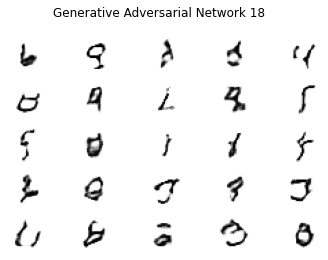

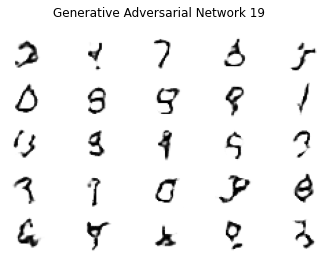

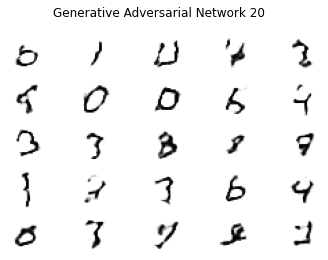

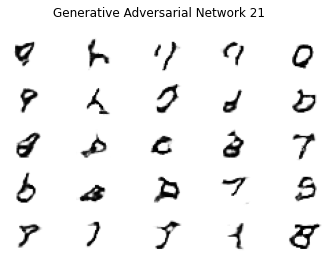

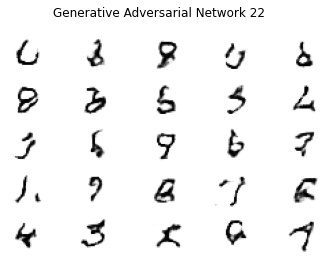

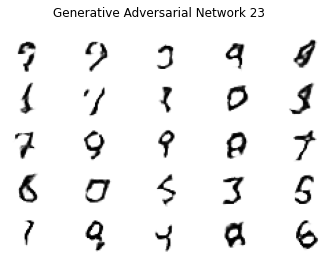

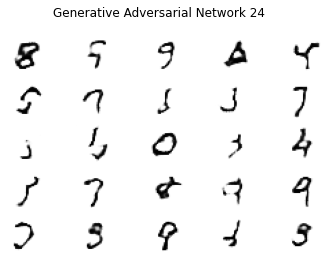

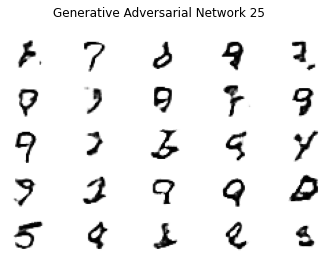

In [10]:
#   Function will plot a 10x10 illustration of the generated images
def plot_data(data, epoch, grid_size=10):
    #   Plot images in a squared grid format
    for i in range(grid_size * grid_size):
        #   Create a subplot using gridsize and i to indicate position
        plt.subplot(grid_size, grid_size, i + 1)

        #   Disable axis labels
        plt.axis('off')

        #   Plot the data provided
        plt.imshow(data[i, :, :, 0], cmap='gray_r')

    plot_title = 'Generative Adversarial Network %d' % (epoch + 1)
    plt.suptitle(plot_title)
    plt.show()

    #   Save the final image
    filename = 'Generator_Model_Plot_%d.png' % (epoch + 1)
    plt.savefig(filename)
    plt.close()


#   As for this example only 5 epochs were run, we loop for each of the 5 models to show the results
for i in range(0, 25, 1):
    model = load_model('Generator_Model_%d.h5' % (i + 1))

    #   Generate latent values to feed to the model
    latent_values = generate_latent_values(100, 25)

    #   Generate images based on the values passed
    gan_generated_data = model.predict(latent_values)

    #   Plot the generated image data
    plot_data(gan_generated_data, i, 5)



